# Анализ и разработка мер по удержанию пользователей банка

От менеджера продукта регионального банка "Метанпром" поступила задача - проанализировать клиентов банка и сегментировать пользователей по количеству потребляемых продуктов.

**Исходные данные** включают в себя личную информацию о пользователях, информацию об используемых услугах, а также содержат факт оттока. Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

**Цель исследования:** разработать меры по удержанию клиентов банка

**Основные задачи:**

1) провести исследовательский анализ данных;

2) сегментировать пользователей на основе данных о количестве потребляемых продуктов;

3) сформулировать и проверить статистические гипотезы;

4) сформулировать основные выводы и разработать рекомендации по удержанию пользователей.

**Презентация:** https://drive.google.com/file/d/1i_PCW6uS2ORYfVbcEUgE_hQ9zKevXLnn/view?usp=sharing 

**Дашборд в Tableau Public:** https://public.tableau.com/app/profile/olga8054/viz/segmentationofbankusers/Dashboard1

##  Загрузка и изучение общей информации о данных

In [1]:
#pip install phik

In [2]:
# импорт необходимых библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import math as mth
import phik
from phik import report
from phik.report import plot_correlation_matrix

import warnings 
warnings.filterwarnings('ignore')

In [3]:
# чтение данных из файла
try:
    bank_data = pd.read_csv('/datasets/bank_dataset.csv')
except:
    bank_data = pd.read_csv('/Users/olgakozlova/Desktop/datasets/bank_dataset.csv')
    
bank_data.head()

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


In [4]:
# общая информация о данных
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [5]:
# просмотр процента пропусков с округлением до целых
(bank_data.isna().mean() * 100).round(0)

userid               0.0
score                0.0
City                 0.0
Gender               0.0
Age                  0.0
Objects              0.0
Balance             36.0
Products             0.0
CreditCard           0.0
Loyalty              0.0
estimated_salary     0.0
Churn                0.0
dtype: float64

Таблица состоит из 10 000 строк и 12 столбцов. Встречаются следующие типы данных: int(8 раз), float(дважды) и object(дважды). Типы данных соответствуют заявленным. В столбце Balance обнаружены пропуски (36 % от общего), которые будут обработаны при предобработке данных.

Согласно документации к данным:

- `userid` — идентификатор пользователя,

- `score` — баллы кредитного скоринга,

- `City` — город,

- `Gender` — пол,

- `Age` — возраст,

- `Objects` — количество объектов в собственности,

- `Balance` — баланс на счёте,

- `Products` — количество продуктов, которыми пользуется клиент,

- `CreditCard` — есть ли кредитная карта,

- `Loyalty` — активный клиент,

- `estimated_salary` — заработная плата клиента,

- `Churn` — ушёл или нет.

### Промежуточные выводы

В датасете содержатся сведения о клиентах банка (личные данные, наличие кредитных карт, состояние счета, факт оттока). Таблица состоит из 10 000 строк и 12 столбцов. Типы данных соответствуют заявленным.

На этапе предобработки в будут исследованы пропущенные значения, дубликаты, заголовки столбцов будут приведены к змеиному регистру. 

## Предобработка данных

Приведем заголовки столбцов к змеиному регистру:

In [6]:
# приведение столбцов к нижнему регистру
bank_data.columns = bank_data.columns.str.lower()

# приведение заголовков столбцов к змеиному регистру (по необходимости)
bank_data = bank_data.rename(columns={'userid':'user_id', 'creditcard':'credit_card'})
bank_data.columns

Index(['user_id', 'score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'credit_card', 'loyalty', 'estimated_salary', 'churn'],
      dtype='object')

Подсчитаем пропущенные значения в данных:

In [7]:
# поиск пропущенных значений
bank_data.isna().sum()

user_id                0
score                  0
city                   0
gender                 0
age                    0
objects                0
balance             3617
products               0
credit_card            0
loyalty                0
estimated_salary       0
churn                  0
dtype: int64

В столбце *balance* обнаружено 3617 (36 % от общего) пропущенных значений. Посмотрим, как распределены значения баланса на счетах у пользователей:

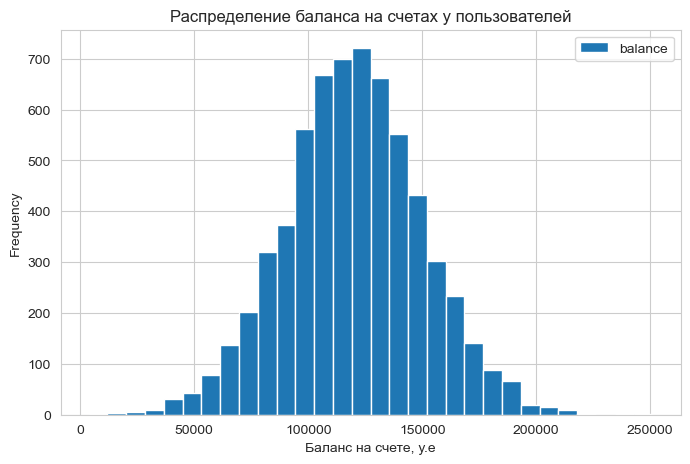

In [8]:
sns.set_style('whitegrid')

bank_data.plot(y='balance', kind='hist', bins=30, figsize=(8,5))
plt.xlabel('Баланс на счете, у.е')
plt.title('Распределение баланса на счетах у пользователей')
plt.show()

Можно сказать, что данные распределены нормально. Посмотрим подробнее на пользователей с неопределенным балансом:

In [9]:
# срез пользователей с незаполненным балансом
balance_nan = bank_data[bank_data['balance'].isna()]
balance_nan

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
6,15635267,822,Ярославль,М,50,7,NaN,2,1,1,10062.80,0
11,15779909,497,Рыбинск,М,24,3,NaN,2,1,0,76390.01,0
12,15675000,476,Ярославль,Ж,34,10,NaN,2,1,0,26260.98,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9989,15648358,841,Рыбинск,М,28,4,NaN,2,1,1,179436.60,0
9992,15699841,726,Рыбинск,М,36,2,NaN,1,1,0,195192.40,0
9994,15762030,800,Ярославль,Ж,29,2,NaN,2,0,0,167773.55,0
9995,15648965,771,Ярославль,М,39,5,NaN,2,1,0,96270.64,0


На основании полученного среза рано делать какие-либо выводы. Однако, очевидно, что удаление такого количества пропусков негативно отразится на результатах корреляционного анализа и статистических тестов. Замена нулевыми значениями также исказит общую картину. 

Сравним пользователей с заполненным и незаполненным балансом по средним значениям данных в колонках:

In [10]:
# средние значения датасета с заполненным балансом 
bank_data.mean().round(2)

user_id             15733676.57
score                    650.53
age                       38.92
objects                    5.01
balance               119827.49
products                   1.53
credit_card                0.71
loyalty                    0.52
estimated_salary      100090.24
churn                      0.20
dtype: float64

In [11]:
# средние значения датасета c незаполненным балансом
balance_nan.mean().round(2)

user_id             15734685.59
score                    649.45
age                       38.43
objects                    5.07
balance                     NaN
products                   1.78
credit_card                0.72
loyalty                    0.52
estimated_salary       98983.56
churn                      0.14
dtype: float64

In [12]:
# медианная заработная плата клиентов с заполненным балансом
print(bank_data['estimated_salary'].median())

# медианная заработная плата клиентов с неизвестным балансом
balance_nan['estimated_salary'].median()

100193.915


98618.79

In [13]:
# в каких городах проживают пользователи с незаполненным балансом?
balance_nan['city'].value_counts()

Ярославль    2418
Рыбинск      1199
Name: city, dtype: int64

In [14]:
# пол клиентов с незаполненным балансом
balance_nan['gender'].value_counts()

М    1963
Ж    1654
Name: gender, dtype: int64

Между датасетами с заполненным и отсутсвующим балансом обнаружены следующие отличия:

1) примечательно, что среди клиентов с незаполненным балансом, отсутствуют жители Ростова Великого;

2) мужчин среди клиентов банка также больше, хоть и незначительно;

3) пользователи с незаполненным балансом реже уходят в отток (~ 14 %), чем пользователи с известным балансом (~ 20 %);

4) клиенты с незаполненным балансом в среднем используют большее количество продуктов, чем клиенты с известным балансом;

5) средняя и медианная заработная плата несущественно ниже, чем у пользователей с заполненным балансом.

Вероятно, наличие в данных пропущенных значений связано с технологической ошибкой, произошедшей с клиентами Ярославля и Рыбинска. Оставим пропущенные значения без изменения.

In [15]:
# наличие полных дубликатов
bank_data.duplicated().sum()

0

Полные дубликаты отсутствуют.

### Промежуточные выводы

1) Заголовки столбцов приведены к змеиному регистру;

2) Пропущенные значения в столбце *balance* решено оставить нетронутыми - 36 % пропусков от общего числа значений возникли в результате технологической ошибки при работе с данными пользователей из Ярославля и Рыбинска;

3) Полные дубликаты не обнаружены.

## Проведение исследовательского анализа данных (EDA)

Посмотрим еще раз на датасет: изучим средние значения и стандартные отклонения:

In [16]:
# числовое описание данных
bank_data.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,10000.0,1.573368e+07,71936.186123,15608437.00,1.567126e+07,1.573347e+07,1.579597e+07,15858426.00
score,10000.0,6.505288e+02,96.653299,350.00,5.840000e+02,6.520000e+02,7.180000e+02,850.00
age,10000.0,3.892180e+01,10.487806,18.00,3.200000e+01,3.700000e+01,4.400000e+01,92.00
objects,10000.0,5.012800e+00,2.892174,0.00,3.000000e+00,5.000000e+00,7.000000e+00,10.00
balance,6383.0,1.198275e+05,30095.056462,3768.69,1.001820e+05,1.198397e+05,1.395123e+05,250898.09
products,10000.0,1.530200e+00,0.581654,1.00,1.000000e+00,1.000000e+00,2.000000e+00,4.00
credit_card,10000.0,7.055000e-01,0.455840,0.00,0.000000e+00,1.000000e+00,1.000000e+00,1.00
loyalty,10000.0,5.151000e-01,0.499797,0.00,0.000000e+00,1.000000e+00,1.000000e+00,1.00
estimated_salary,10000.0,1.000902e+05,57510.492818,11.58,5.100211e+04,1.001939e+05,1.493882e+05,199992.48
churn,10000.0,2.037000e-01,0.402769,0.00,0.000000e+00,0.000000e+00,0.000000e+00,1.00


Изучим подробнее представляющие интерес признаки. Построим столбчатые гистограммы и распределения, для этого объявим функцию:

In [17]:
def histograms(data, column, title, xlabel, ylabel, kde):
    """Функция возвращает столбчатую гистограмму/распределение признака. Принимает на вход:
        data - датасет,
        column - столбец,
        title - заголовок графика,
        xlabel - название оси Х,
        ylabel - название оси У,
        kde - оценка плотности ядра (True/False)
    """
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(8,5))
    sns.histplot(data=data, x=column, kde=kde)
    plt.title(title, fontsize=15)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

Для подтверждения визуализации объявим функцию, возвращающую числовое описание значений столбца:

In [18]:
def percentage(feature, decimal_place):
    """Функция возвращает таблицу с уникальными значениями признака,  их встречаемость и % от общего числа клиентов. 
        Принимает на вход:
        feature - колонка датасета (признак),
        decimal_place - количество знаков после запятой
    """
    percentage = bank_data[feature].value_counts().reset_index() # уникальные значения и их встречаемость
    percentage.columns = [feature, 'count'] #переиментование столбцов
    # % от общего числа клиентов
    percentage['% of total']= round(percentage['count'] / percentage['count'].sum() * 100, decimal_place) 
    return percentage

**Баллы кредитного скоринга (score):**

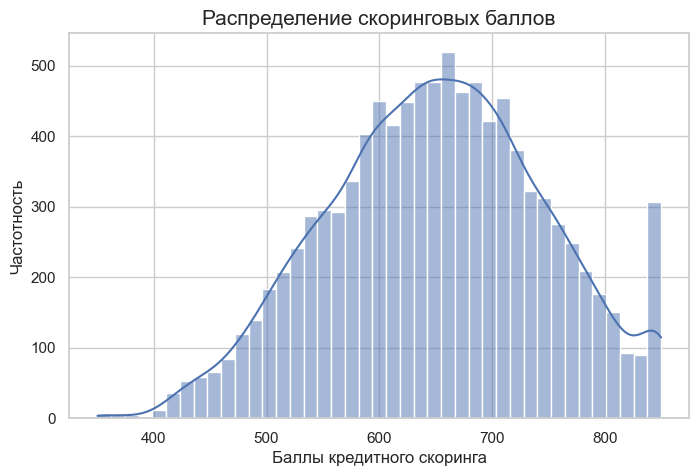

In [19]:
# вызов функции для построения распределения клиентов по баллам
histograms(bank_data, 'score', 'Распределение скоринговых баллов', 'Баллы кредитного скоринга', 'Частотность', True)

От величины скорингового балла зависит решение банка о предоставлении кредита. Чем выше балл, тем клиент является более платежеспособным заемщиком. В среднем, чтобы кредит был одобрен, значение скорингового балла должно быть не менее 600 баллов (Источник: https://www.sravni.ru/enciklopediya/info/skoringovyi-ball/).

В нашем случае и среднее арифметическое и медианное значение скорингового балла составляет 650. То есть, как минимум половина клиентов могут рассчитывать на одобрение им кредита. При этом скоринговые баллы варьируются от 350 до 850.

In [20]:
# количество клиентов с максимальным скоринговым баллом
bank_data.query('score == 850')['score'].count()

233

Максимальное количество баллов накопило 233 клиента.

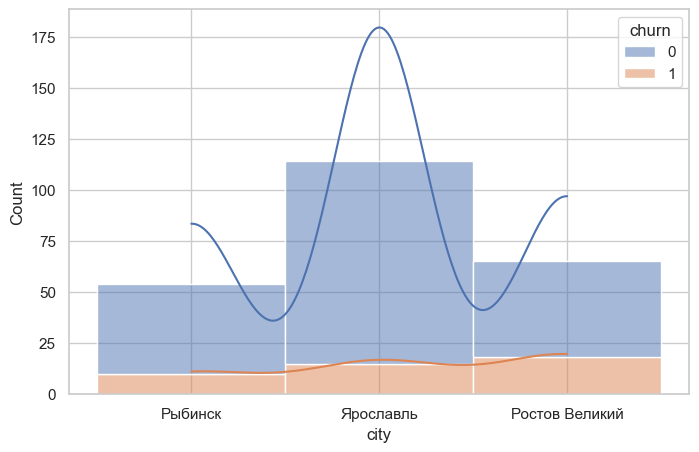

In [21]:
# распределение самых надежных заемщиков по городам
plt.figure(figsize=(8,5))
sns.histplot(data=bank_data.query('score == 850'), x='city', hue="churn", multiple="stack", kde=True)
plt.show()

Самые надежные заемщики чаще всего проживают в Ярославле. Почему так? Вероятно, это связано с тем, что в целом в этом городе больше клиентов банка. А может в Ярославле ниже средний возраст и клиенты чаще берут ипотеку? Рассмотрим распределение клиентов по городам: 

**Город (city):**

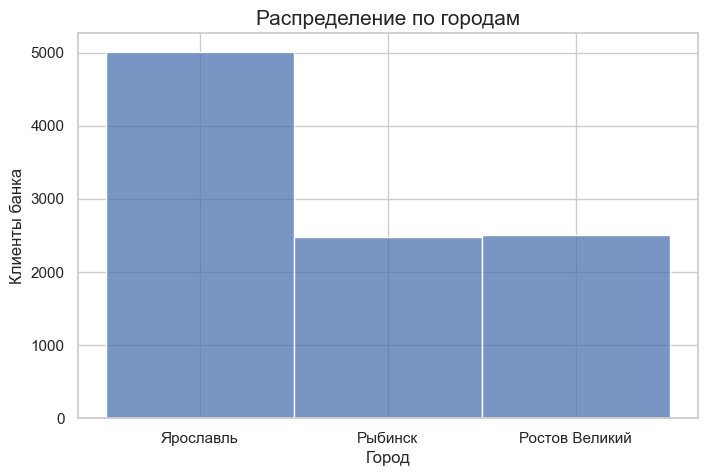

In [22]:
# вызов функции для построения столбчатой гистограммы клиентов по городам
histograms(bank_data, 'city', 'Распределение по городам', 'Город', 'Клиенты банка', False)

In [23]:
# вызов функции percentage
percentage('city', 0)

,city,count,% of total
0,Ярославль,5014,50.0
1,Ростов Великий,2509,25.0
2,Рыбинск,2477,25.0


Половина всех клиентов банка проживают в Ярославле, оставшаяся половина равномерно распределена между Ростовом Великим и Рыбинском.

На 1 января 2023 год население Ярославля - 570 824 человека, Ростова Великого - 27 656 человек, Рыбинска - 173 910 человек (Источник: https://rosstat.gov.ru/compendium/document/13282).

**Пол (gender):**

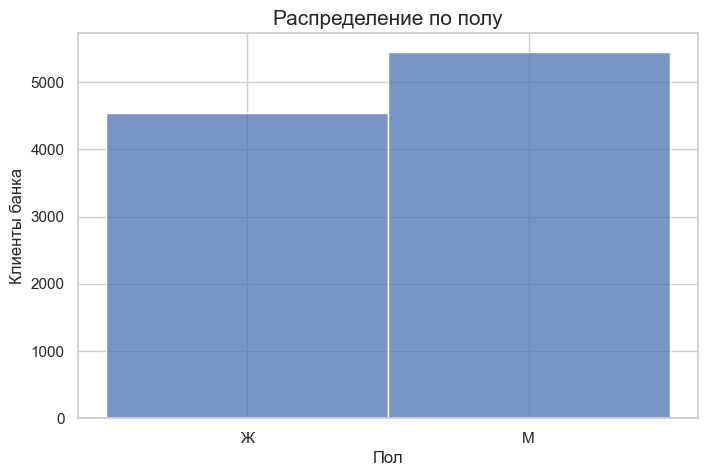

In [24]:
# вызов функции для построения столбчатой гистограммы клиентов по полу
histograms(bank_data, 'gender', 'Распределение по полу', 'Пол', 'Клиенты банка', False)

In [25]:
# вызов функции percentage
percentage('gender', 0)

,gender,count,% of total
0,М,5457,55.0
1,Ж,4543,45.0


Среди клиентов банка преобладают мужчины - 55 % против 45 % женщин.

**Возраст (age):**

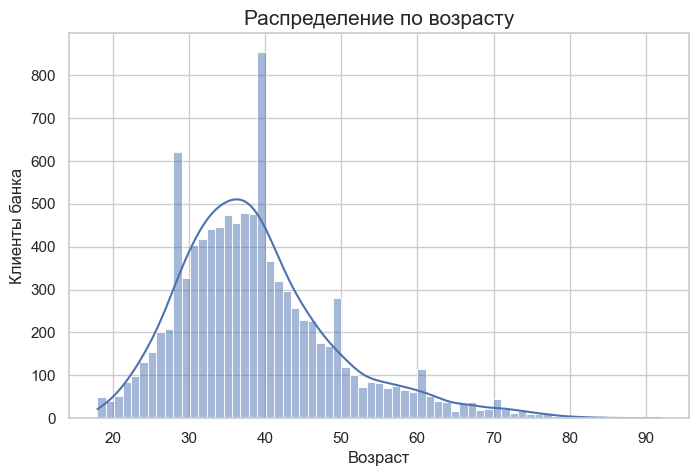

In [26]:
# вызов функции для построения распределения клиентов по возрасту
histograms(bank_data, 'age', 'Распределение по возрасту', 'Возраст', 'Клиенты банка', True)

Возраст клиентов варьируется от 18 до 92 лет, из-за чего данные смещены вправо. В среднем возраст клиента составляет 39 лет. Медианный возраст ниже - 37 лет.

**Количество объектов в собственности (objects):**

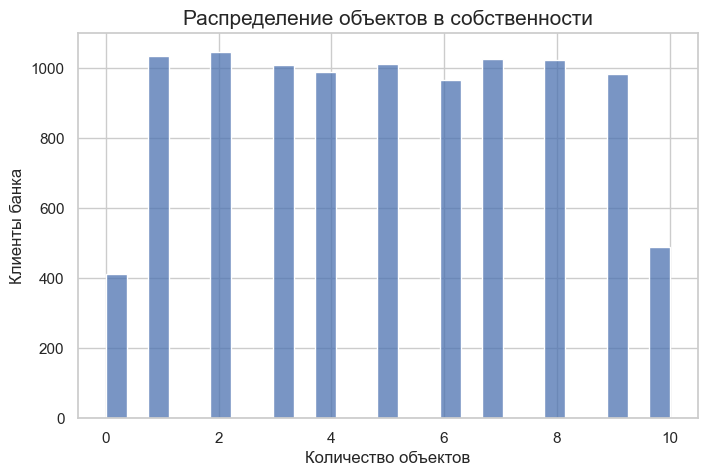

In [27]:
# вызов функции для построения столбцовой гистограммы количество объектов в собственности
histograms(bank_data, 'objects', 'Распределение объектов в собственности', 'Количество объектов', 'Клиенты банка', False)

In [28]:
# вызов функции percentage
percentage('objects', 2)

,objects,count,% of total
0,2,1048,10.48
1,1,1035,10.35
2,7,1028,10.28
3,8,1025,10.25
4,5,1012,10.12
5,3,1009,10.09
6,4,989,9.89
7,9,984,9.84
8,6,967,9.67
9,10,490,4.90


В среднем у клиентов 5 объектов собственности. У 4 % клиентов собственность отсутствует, у 4.9 % - в собственности максимальное количество объектов (10).

**Количество продуктов, которыми пользуется клиент (products):**

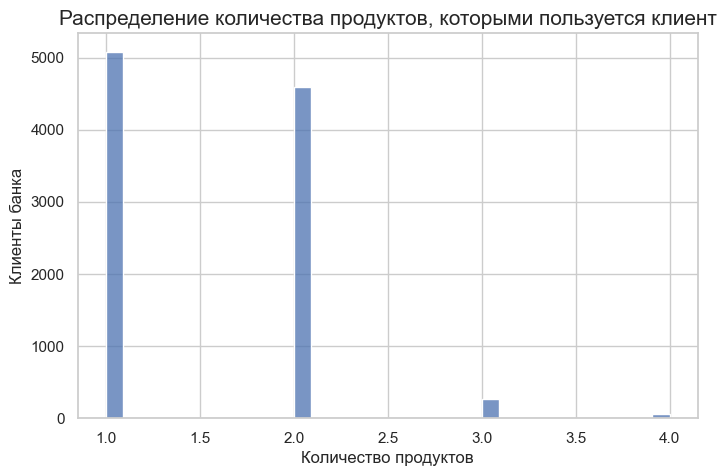

In [29]:
# вызов функции для построения столбчатой гистограммы количество продуктов у клиентов
histograms(bank_data, 'products', 'Распределение количества продуктов, которыми пользуется клиент', 'Количество продуктов', 'Клиенты банка', False)

In [30]:
# вызов функции percentage
percentage('products', 0)

,products,count,% of total
0,1,5084,51.0
1,2,4590,46.0
2,3,266,3.0
3,4,60,1.0


Большинство клиентов пользуются одним (51 %) и двумя (46 %) продуктами соответственно. Меньше 1 % клиентов используют максимальное количество продуктов банка.

Под продуктами банка вероятно следует понимать: кредиты, вклады, ипотеки, инвестиционные счета.

**Кредитная карта (credit_card):**

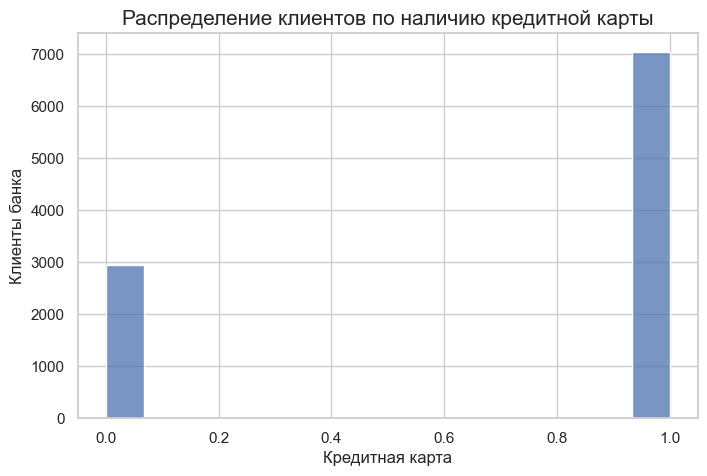

In [31]:
# вызов функции для построения столбчатой гистограммы клиентов по наличию кредитной карты, 0 - нет, 1 - да
histograms(bank_data, 'credit_card', 'Распределение клиентов по наличию кредитной карты', 'Кредитная карта', 'Клиенты банка', False)

In [32]:
# вызов функции percentage
percentage('credit_card', 1)

,credit_card,count,% of total
0,1,7055,70.6
1,0,2945,29.4


У 71 % пользователей оформлена кредитная карта.

**Активный клиент (loyalty):**

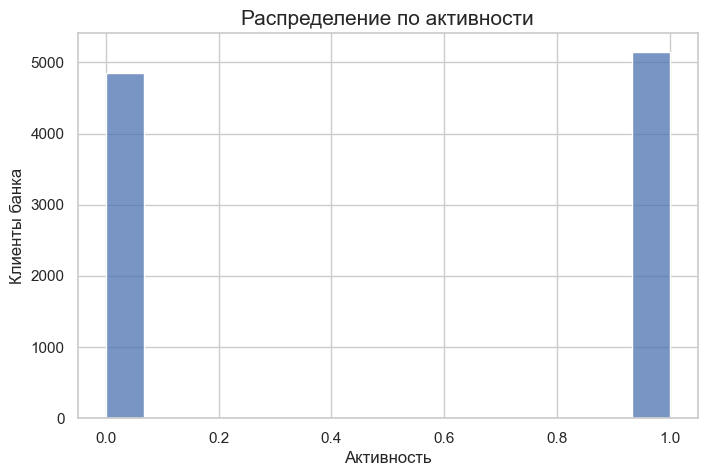

In [33]:
# вызов функции для построения столбчатой гистограммы клиентов по активности, 0 - нет,  1 - да
histograms(bank_data, 'loyalty', 'Распределение по активности', 'Активность', 'Клиенты банка', False)

In [34]:
# вызов функции percentage
percentage('loyalty', 1)

,loyalty,count,% of total
0,1,5151,51.5
1,0,4849,48.5


Активных клиентов немного больше (51 %), чем неактивных.

**Оцененная заработная плата клиента (estimated_salary):**

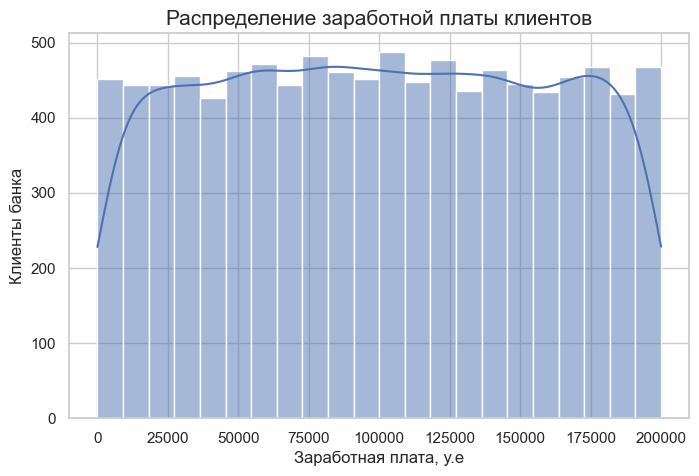

In [35]:
# вызов функции для построения распределения клиентов по зарплате
histograms(bank_data, 'estimated_salary', 'Распределение заработной платы клиентов', 'Заработная плата, у.е', 'Клиенты банка', True)

Медианная заработная плата клиентов составляет 100193.9 у.е.

**Ушел или остался клиент (churn):**

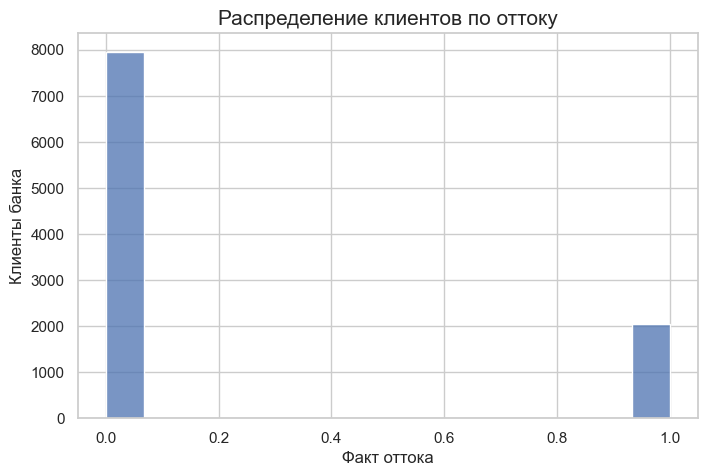

In [36]:
# вызов функции для построения столбчатой гистограммы клиентов по оттоку
histograms(bank_data, 'churn', 'Распределение клиентов по оттоку', 'Факт оттока', 'Клиенты банка', False)

In [37]:
# вызов функции percentage
percentage('churn', 1)

,churn,count,% of total
0,0,7963,79.6
1,1,2037,20.4


В среднем 20 % клиентов перестали пользоваться услугами банка. 

Посмотрим на средние значения количественных переменных в двух группах — тех, кто ушел в отток и тех, кто остался:

In [38]:
# средние значения признаков в двух группах (# 0 - 'остался', 1 - 'ушёл')
bank_data.groupby('churn').agg('mean').T

churn,0,1
user_id,1.573390e+07,1.573279e+07
score,6.518532e+02,6.453515e+02
age,3.740839e+01,4.483800e+01
objects,5.033279e+00,4.932744e+00
balance,1.195359e+05,1.207470e+05
products,1.544267e+00,1.475209e+00
credit_card,7.071455e-01,6.990673e-01
loyalty,5.545649e-01,3.608247e-01
estimated_salary,9.973839e+04,1.014657e+05


- Скоринговый балл ушедших клиентов в среднем на 7 баллов ниже;

- Средний возраст ушедших в отток почти 45 лет, тогда, как у оставшихся клиентов - 37;

- Большая часть ушедших клиентов (~ 64 %) не были активными;

- Оцененная заработная плата ушедших незначительно выше, чем у оставшихся.

Построим и визуализируем матрицу корреляций. Воспользуемся one-hot кодировкой, чтобы исследовать зависимости по городам:

In [39]:
def ohe (data, feature):
    """Функция возвращает преобразованную категориальную переменную 'city'
        в три новых категориальный столбца и присваивает этим столбцам двоичное значение 1 или 0
    """
    for i in data[feature].unique():
        data[feature + '=' + i] = (data[feature] == i).astype(float)
    return data.sample()

In [40]:
# вызов функции ohe
ohe(bank_data, 'city')

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,city=Ярославль,city=Рыбинск,city=Ростов Великий
9491,15662410,649,Ярославль,Ж,35,4,108306.44,1,1,1,192486.24,0,1.0,0.0,0.0


In [41]:
# копия датасета
bank_data_copy = bank_data.copy()

# удаление из копии столбца 'city'
bank_data_copy.drop(columns = ['city'], axis=1, inplace=True)
bank_data_copy.sample()

,user_id,score,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,city=Ярославль,city=Рыбинск,city=Ростов Великий
4013,15696512,720,Ж,57,1,162082.31,4,0,0,27145.73,1,0.0,0.0,1.0


Во избежание мультиколлинеарности признаков построим 3 матрицы корреляций, учитывая при этом города:

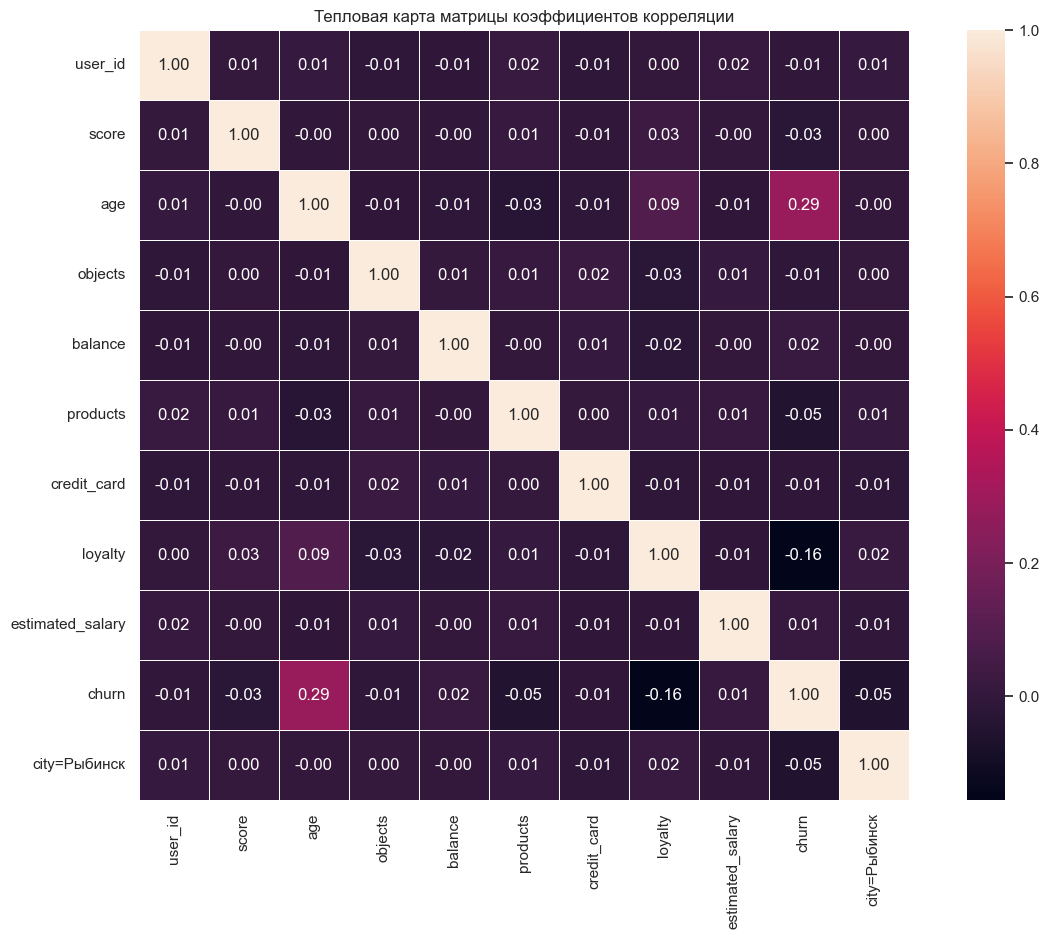

In [42]:
# матрица корреляций Пирсона (Рыбинск)
cm1 = bank_data_copy.drop(columns = ['city=Ярославль', 'city=Ростов Великий'], axis=1).corr()

# визуальное представление матрицы корреляций в виде тепловой карты
plt.figure(figsize= (15,10))
sns.heatmap(cm1, annot=True, square=True, fmt = '0.2f', linewidths=.5)
plt.title('Тепловая карта матрицы коэффициентов корреляции')
plt.show()

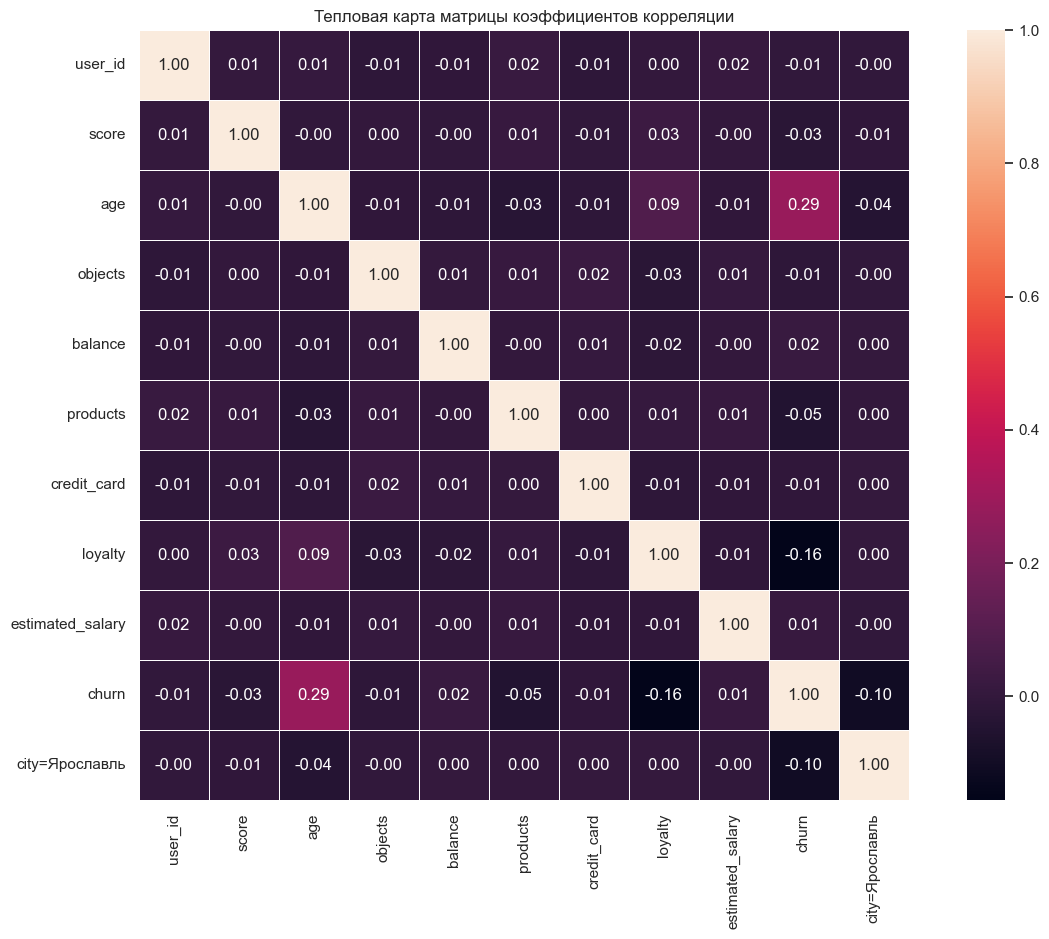

In [43]:
# матрица корреляций Пирсона (Ярославль)
cm2 = bank_data_copy.drop(columns = ['city=Рыбинск', 'city=Ростов Великий'], axis=1).corr()

# визуальное представление матрицы корреляций в виде тепловой карты
plt.figure(figsize= (15,10))
sns.heatmap(cm2, annot=True, square=True, fmt = '0.2f', linewidths=.5)
plt.title('Тепловая карта матрицы коэффициентов корреляции')
plt.show()

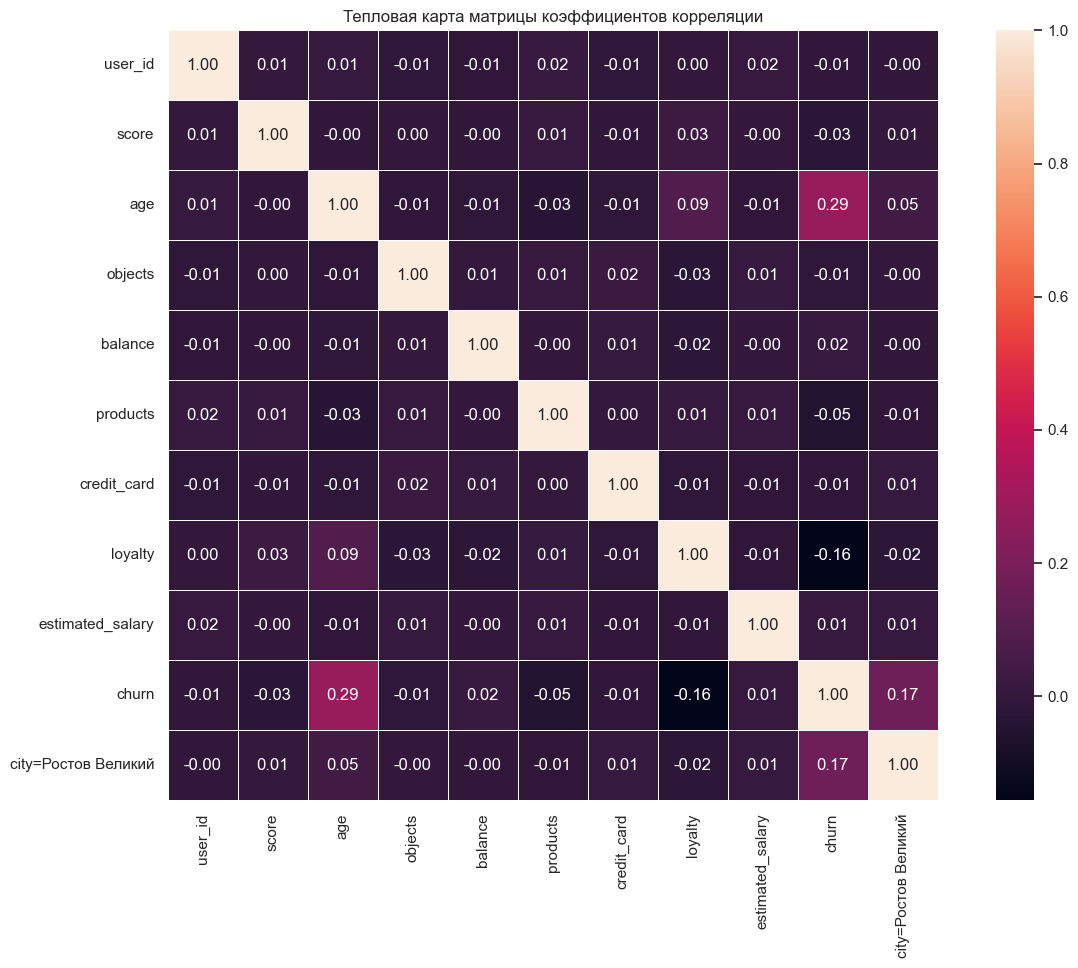

In [44]:
# матрица корреляций Пирсона (Ростов Великий)
cm3 = bank_data_copy.drop(columns = ['city=Ярославль', 'city=Рыбинск'], axis=1).corr()

# визуальное представление матрицы корреляций в виде тепловой карты
plt.figure(figsize= (15,10))
sns.heatmap(cm3, annot=True, square=True, fmt = '0.2f', linewidths=.5)
plt.title('Тепловая карта матрицы коэффициентов корреляции')
plt.show()

Среди имеющихся признаков наиболее сильно с целевой переменной 'churn' коррелирует 'age' (возраст) и 'Ростов Великий'.

Возможно признаки имеют нелинейные связи, и коэффициент корреляции Пирсона их не учитывает, поэтому изучим коэффициенты корреляции Phik ( 𝜙 k) для трех городов. При использовании методов, которые способны выявлять нелинейные зависимости, можно не строить матрицы корреляций для множества срезов:

interval columns not set, guessing: ['user_id', 'score', 'age', 'objects', 'balance', 'products', 'credit_card', 'loyalty', 'estimated_salary', 'churn', 'city=Ярославль', 'city=Рыбинск', 'city=Ростов Великий']


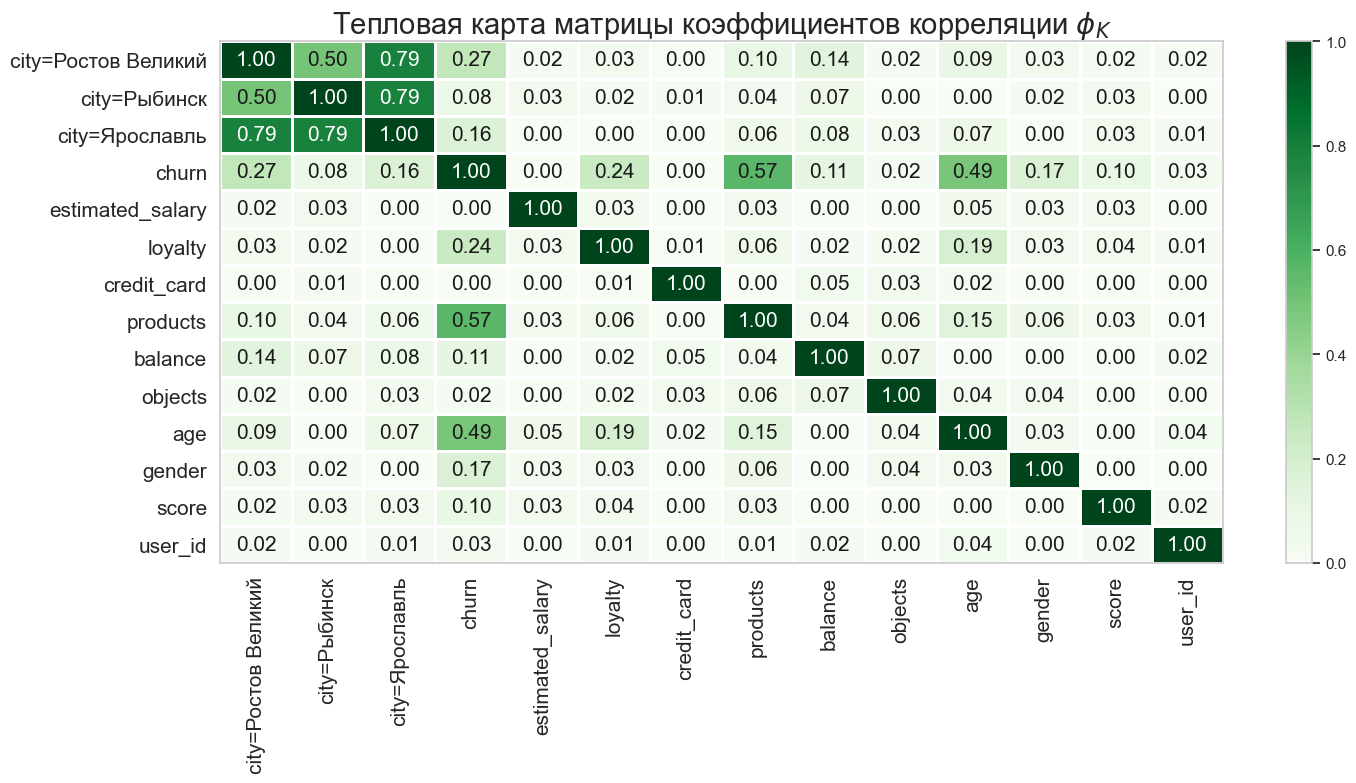

In [45]:
# матрица корреляции phi_k между всеми переменными
phik_overview = bank_data_copy.phik_matrix()

# отображение результатов матрици корреляции в виде тепловой карты
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"Тепловая карта матрицы коэффициентов корреляции $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(15, 8))
plt.tight_layout()

Можно заметить, что помимо 'age' - 'churn', имеется достаточно высокая корреляция между 'products' и 'churn', а также  'loyalty' - 'churn'. К высоким значениям корреляции с 'churn' добавляется 'Ростов Великий'.

При оценке корреляций следует смотреть не только на коэффициенты, но и на их статистическую значимость. Потому что, большая корреляция может оказаться статистически незначимой, и наоборот:

interval columns not set, guessing: ['user_id', 'score', 'age', 'objects', 'balance', 'products', 'credit_card', 'loyalty', 'estimated_salary', 'churn', 'city=Ярославль', 'city=Рыбинск', 'city=Ростов Великий']


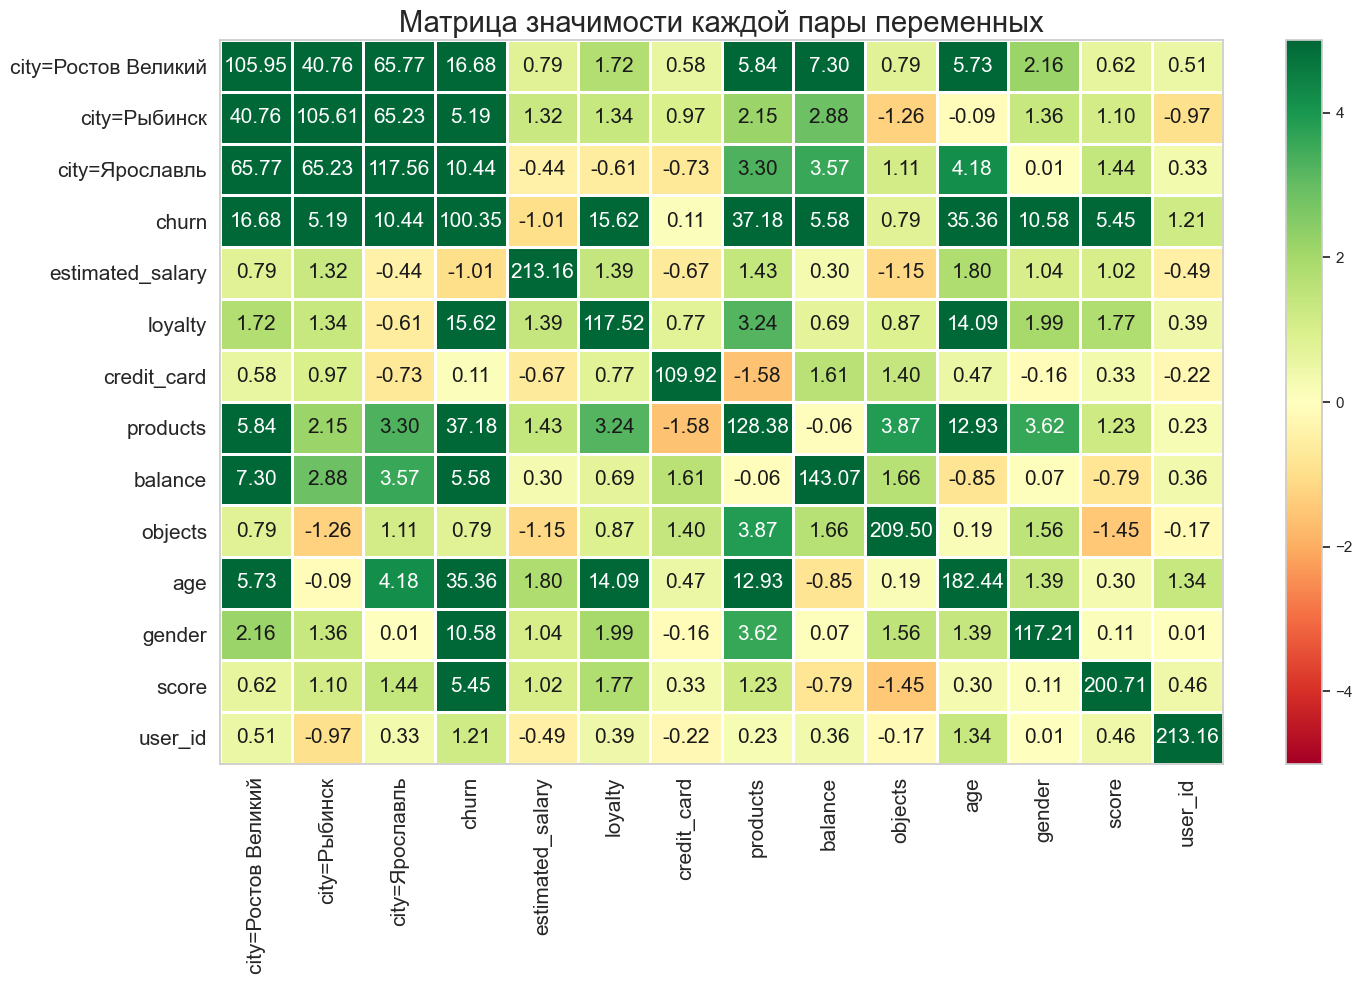

In [46]:
# матрица значимости (выраженная как одностор. z-тест) проверки гипотезы зависимости каждой пары переменных

significance_overview = bank_data_copy.significance_matrix()
plot_correlation_matrix(significance_overview.values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title="Матрица значимости каждой пары переменных", 
                        usetex=False, fontsize_factor=1.5, figsize=(15, 10))
plt.tight_layout()

По матрице значимости видно, что относительно высокие значения коэффициента корреляции для всех выбранных выше пар статистически значимы.

interval columns not set, guessing: ['user_id', 'score', 'age', 'objects', 'balance', 'products', 'credit_card', 'loyalty', 'estimated_salary', 'churn', 'city=Ярославль', 'city=Рыбинск', 'city=Ростов Великий']


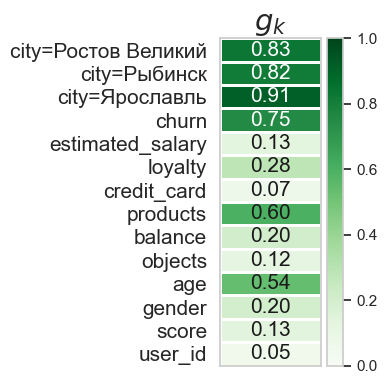

In [47]:
# глобальные коэффициенты корреляции на основе корреляционной матрицы phi_k (общая корреляция одной переменной со всеми другими переменными в наборе)

global_correlation, global_labels = bank_data_copy.global_phik()

plot_correlation_matrix(global_correlation, 
                        x_labels=[''], y_labels=global_labels, 
                        vmin=0, vmax=1, figsize=(4,4),
                        color_map="Greens", title=r"$g_k$",
                        fontsize_factor=1.5,)
plt.tight_layout()

Переменные 'churn', 'products', 'age', 'loyalty' имеют высокие значения глобальной метрики корреляции.

### Промежуточные выводы

Из полученных распределений, столбчатых гистограмм и средних значений следует:
    
- средний скоринговый балл составляет 650. Максимальный балл накопили 233 клиента;

- половина всех клиентов банка проживают в Ярославле, оставшаяся половина равномерно распределена между Ростовом Великим и Рыбинском;

- среди клиентов банка преобладают мужчины - 55 %;

- средний возраст клиента почти 39 лет;

- в среднем у клиентов 5 объектов собственности. У 4 % клиентов собственность отсутствует, у ~5 % - в собственности максимальное количество объектов (10);

- большинство клиентов пользуются одним (51 %) и двумя (46 %) продуктами соответственно. Меньше 1 % клиентов используют максимальное количество продуктов банка;

- у 71 % клиентов оформлена кредитная карта;

- активных клиентов немного больше (51 %), чем неактивных;

- медианная заработная плата клиентов составляет 100193.9 у.е;

- в среднем 20 % клиентов банка ушли в отток.

Отмечено, что стандартное отклонение тем больше, чем сильнее отличаются средние значения и медианы. Это может говорить о неустойчивости среднего.


Для ушедших в отток клиентов характерно:

- Скоринговый балл в среднем на 7 баллов ниже;

- Средний возраст почти 45 лет, тогда, как у оставшихся клиентов - 37;

- Большая часть (~ 64 %) не были активными;

- Оцененная заработная плата незначительно выше, чем у оставшихся.

Линейный коэффициент корреляции Пирсона показал взаимосвязь переменной 'churn' и 'age', 'Ростов Великий'.

Коэффициент корреляции Phik позволил выявить больше взаимосвязей с 'churn': 'products', 'age', 'Ростов Великий', 'loyalty'.

## Сегментация пользователей на основе данных о количестве потребляемых продуктов

Посмотрим на средние значения признаков по количеству продуктов:

In [48]:
# средние значения признаков по количеству продуктов
bank_data.groupby('products').agg('mean').T

products,1,2,3,4
user_id,1.573237e+07,1.573484e+07,1.574182e+07,1.571936e+07
score,6.491210e+02,6.521887e+02,6.481053e+02,6.535833e+02
age,3.967309e+01,3.775359e+01,4.319549e+01,4.568333e+01
objects,4.974626e+00,5.051852e+00,5.003759e+00,5.300000e+00
balance,1.198942e+05,1.196609e+05,1.194757e+05,1.222606e+05
credit_card,7.037766e-01,7.071895e-01,7.142857e-01,6.833333e-01
loyalty,5.041306e-01,5.328976e-01,4.248120e-01,4.833333e-01
estimated_salary,9.948726e+04,1.004520e+05,1.043181e+05,1.047637e+05
churn,2.771440e-01,7.581699e-02,8.270677e-01,1.000000e+00
city=Ярославль,4.944925e-01,5.156863e-01,3.909774e-01,4.833333e-01


In [49]:
# сводная таблица число ушедших пользователей в зависимости от количества используемых продуктов
bank_data.pivot_table(index = 'churn', columns = 'products', values = 'score', aggfunc = 'count')

products,1,2,3,4
churn,,,,
0,3675.0,4242.0,46.0,NaN
1,1409.0,348.0,220.0,60.0


Из средних значений следует:

1) Наивысший скоринговый балл (654) у пользователей 4-х продуктов, наименьший (648) - пользователи 3-х продуктов;

2) С возрастом увеличивается количество используемых продуктов, 43 года - 3 продукта, 46 лет - 4 продукта;

3) Среднее количество объектов в собственности - 5 для всех;

4) Баланс на счете и заработная плата держатся примерно на одном уровне независимо от количества продуктов;

5) В среднем у 70 % клиентов есть кредитная карта;

6) Пользователи 3-х и 4-х продуктов менее активные, чем пользователи одного и двух продуктов;

7) Пользователи 4-х продуктов полностью ушли в отток, 83 % пользователей с 3-мя продуктами покинули банк, наименьшая доля оттока характерна для клиентов с 2-мя продуктами.

Рассмотрим распределения признаков в разбивке по количеству продуктов с учетом ушедших и оставшихся клиентов. Для этого объявим функции:

In [50]:
def violinplot(data, y, title, ylabel):
    """Функция возвращает violinplot() для непрерывных параметров. Принимает на вход:
        data - датасет,
        y - значения по оси У,
        title - заголовок графика,
        ylabel - подпись оси У
    """
    plt.figure(figsize=(10,6))
    ax = sns.violinplot(x='products', y=y, hue='churn',
                        data=data, split=True, palette='Set1',
                        scale='count', inner='quartile')
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Количество продуктов', fontsize=13)
    ax.set_ylabel(ylabel, fontsize=13)
    plt.show()

In [51]:
def barplot(columns, aggfunc, title, ylabel):
    """Функция возвращает plot(kind = 'bar') для дискретных параметров. Принимает на вход:
        columns - значения, по которым происходит группировка
        title - заголовок,
        ylabel - подпись оси У
    """ 
    colors = ['#F9D923', '#36AE7C', '#F55353', '#143F6B', '#9FC088', '#8FBDD3', '#F190B7', '#711A75', '#019267', '#FF7BA9', '#F76E11']
    bank_data.pivot_table(index = 'products', columns = columns, 
                          values = 'churn', aggfunc = aggfunc).plot(kind='bar', color=colors, figsize=(10,6))
    plt.title(title, fontsize=16)
    plt.xlabel('Количество продуктов', fontsize=13)
    plt.ylabel(ylabel, fontsize=13)
    plt.xticks(rotation = 0)
    plt.show()

In [52]:
def pivoting(data, index, columns, values, aggfunc, decimal_place):
    """Функция возвращает сводную таблицу. Принимает на вход:
        data - датасет,
        index - столбец/столбцы, по которым происходит группировка данных,
        columns - столбец, по значениям которого происходит группировка,
        values - значения таблицы,
        aggfunc - функция, применяемая к значениям,
        decimal_place - количество знаков после запятой
    """
    pivot_table = round(data.pivot_table(index = index, columns = columns, values = values, aggfunc = aggfunc), decimal_place)  
    return pivot_table

**Баллы кредитного скоринга:**

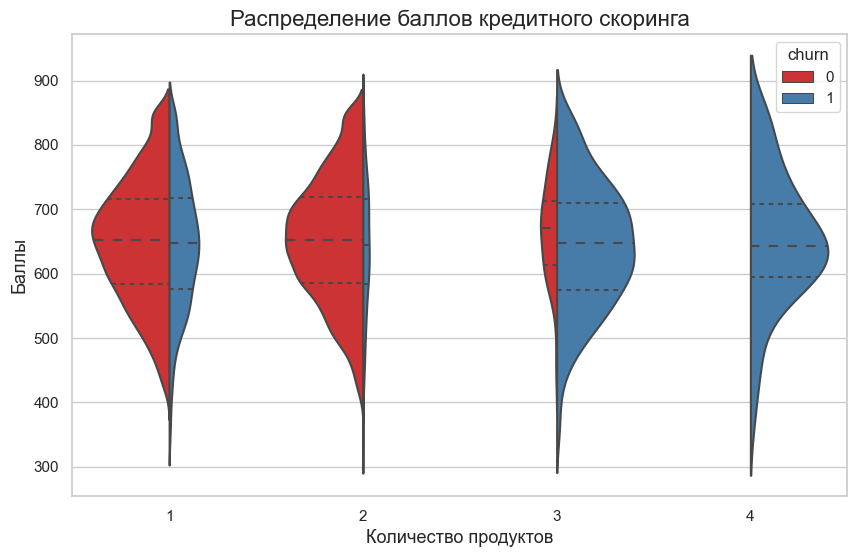

In [53]:
# вызов функции для вывода распределения кредитных баллов (горизонтальные линии - квартили)
violinplot(bank_data, 'score', 'Распределение баллов кредитного скоринга', 'Баллы')

In [54]:
# средний кредитный балл по продуктам с учетом оттока
pivoting(bank_data, 'churn', 'products', 'score', 'mean', 0)

products,1,2,3,4
churn,,,,
0,650.0,653.0,670.0,NaN
1,646.0,644.0,644.0,654.0


Распределение скоринговых баллов выглядит нормальным. Вне зависимости от количества продуктов клиенты ушедшие в отток в среднем имели более низкие баллы кредитного скоринга.

**Пол:**

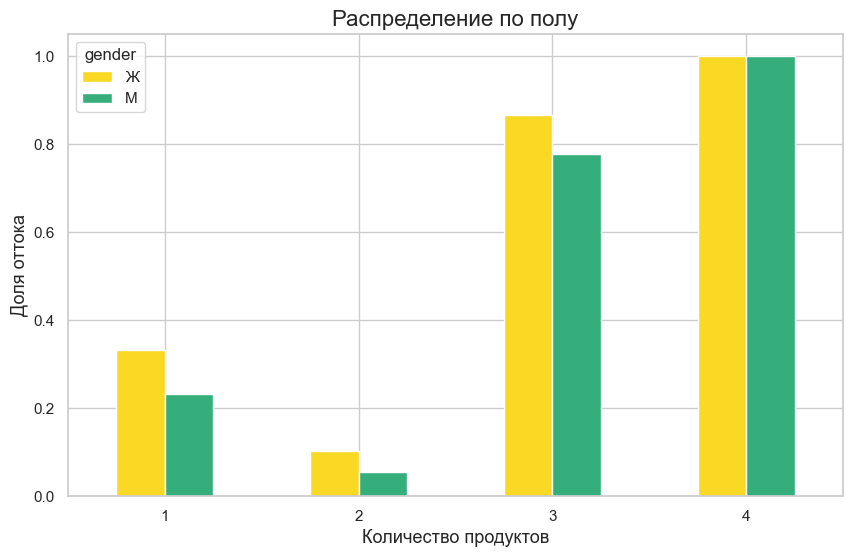

In [55]:
# вызов функции barplot распределение по полу
barplot('gender', 'mean', 'Распределение по полу', 'Доля оттока')

In [56]:
# доля оттока клиентов по продуктам и полу
pivoting(bank_data, 'gender', 'products', 'churn', 'mean', 2)

products,1,2,3,4
gender,,,,
Ж,0.33,0.10,0.87,1.0
М,0.23,0.05,0.78,1.0


In [57]:
# количество ушедших клиентов по продуктам и полу
pivoting(bank_data, 'gender', 'products', 'churn', 'count', 0)

products,1,2,3,4
gender,,,,
Ж,2296,2060,149,38
М,2788,2530,117,22


Мужчины предпочитают пользоваться 1-м и 2-мя продуктами, в то время, как среди пользователей 3-х и 4-х продуктов преобладают женщины. 

Женщины чаще мужчин уходят в отток.

**Город:**

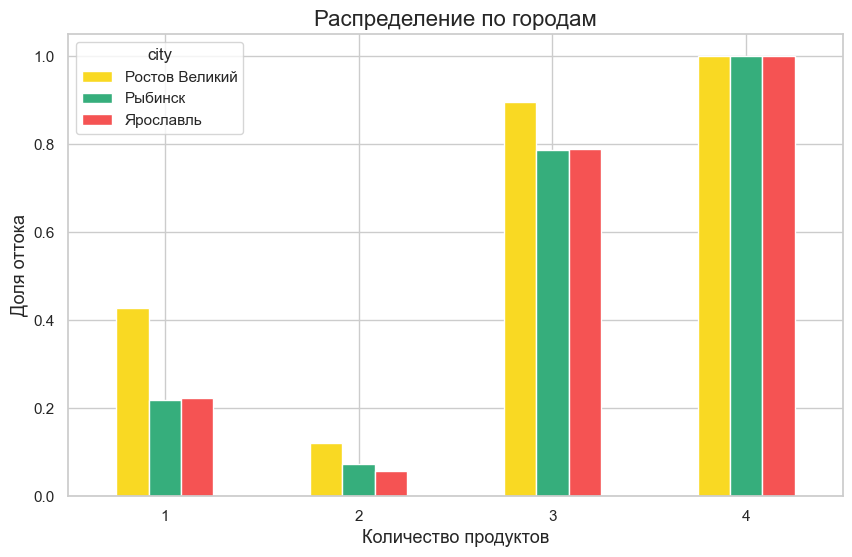

In [58]:
# вызов функции barplot распределение по городам
barplot('city', 'mean', 'Распределение по городам', 'Доля оттока')

In [59]:
# доля оттока клиентов по продуктам и городам
pivoting(bank_data, 'city', 'products', 'churn', 'mean', 2)

products,1,2,3,4
city,,,,
Ростов Великий,0.43,0.12,0.90,1.0
Рыбинск,0.22,0.07,0.79,1.0
Ярославль,0.22,0.06,0.79,1.0


In [60]:
# средний возраст клиентов по продуктам и городам
pivoting(bank_data, 'city', 'products', 'age', 'mean', 1)

products,1,2,3,4
city,,,,
Ростов Великий,40.6,38.3,43.7,44.4
Рыбинск,39.7,37.9,40.9,45.1
Ярославль,39.2,37.5,44.2,46.9


В отношении оттока поведение жителей Рыбинска и Ярославля можно считать похожим. Жители Ростова Великого активнее покидают банк.

Как было отмечено ранее, все пользователи 4-х продуктов ушли в отток. 90 % клиентов Ростова Великого, по 79 % клиентов Рыбинска и Ярославля, пользовавшихся 3-мя продуктами также прекратили отношения с банком.

В среднем меньший отток клиентов среди тех, кто использует 2 продукта.

В среднем клиенты 2-х продуктов из всех городов моложе, а пользователи 4-х продуктов старше.

**Возраст:**

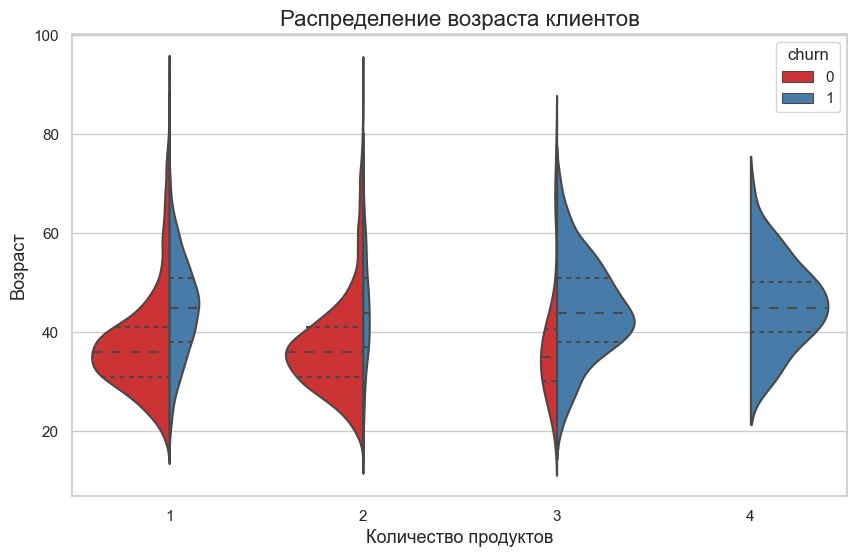

In [61]:
# вызов функции для вывода распределения возраста (горизонтальные линии - квартили)
violinplot(bank_data, 'age', 'Распределение возраста клиентов', 'Возраст')

Данные распределены нормально. Наглядно видно, что медианный возраст ушедших клиентов больше возраста оставшихся. 

Проведем категоризацию, выделив возрастные группы:

In [62]:
def age_group(age):
    """
    Возвращает возврастную группу по значению возраста age, используя правила:
    - 'до 24 лет', если age <= 24 года;
    - 'от 25 до 44 лет', если age более 24 и менее 45, включая 25 и 44;
    - 'от 45 до 64 лет' — если age более 44 и менее 65, включая 45 и 64;
    - '65 лет и старше' — во всех остальных случаях.
    """
    
    if age <= 18:
        return 'до 24 лет'
    if age <= 44:
        return 'от 25 до 44 лет'
    if age <= 64:
        return 'от 45 до 64 лет'
    return '65 лет и старше'

In [63]:
# вызов функции age_group с помощью apply
bank_data['age_group'] = bank_data['age'].apply(age_group)
bank_data.tail()

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,city=Ярославль,city=Рыбинск,city=Ростов Великий,age_group
9995,15648965,771,Ярославль,М,39,5,NaN,2,1,0,96270.64,0,1.0,0.0,0.0,от 25 до 44 лет
9996,15612628,516,Ярославль,М,35,10,57369.61,1,1,1,101699.77,0,1.0,0.0,0.0,от 25 до 44 лет
9997,15627268,709,Ярославль,Ж,36,7,NaN,1,0,1,42085.58,1,1.0,0.0,0.0,от 25 до 44 лет
9998,15725091,772,Ростов Великий,М,42,3,75075.31,2,1,0,92888.52,1,0.0,0.0,1.0,от 25 до 44 лет
9999,15671055,792,Ярославль,Ж,28,4,130142.79,1,1,0,38190.78,0,1.0,0.0,0.0,от 25 до 44 лет


In [64]:
# доля оттока клиентов по продуктам и возрастным группам
pivoting(bank_data, 'age_group', 'products', 'churn', 'mean', 2)

products,1,2,3,4
age_group,,,,
65 лет и старше,0.19,0.07,0.56,1.0
до 24 лет,0.09,0.09,NaN,NaN
от 25 до 44 лет,0.18,0.05,0.74,1.0
от 45 до 64 лет,0.58,0.22,0.99,1.0


In [65]:
# средние значения признаков по возрастным категориям
bank_data.groupby('age_group').mean()

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,city=Ярославль,city=Рыбинск,city=Ростов Великий
age_group,,,,,,,,,,,,,
65 лет и старше,1.573561e+07,662.652482,70.851064,5.046099,118224.970702,1.521277,0.712766,0.865248,100369.857589,0.152482,0.500000,0.251773,0.248227
до 24 лет,1.574600e+07,686.681818,18.000000,4.818182,124409.332143,1.500000,0.636364,0.590909,85102.389545,0.090909,0.500000,0.227273,0.272727
от 25 до 44 лет,1.573324e+07,651.145981,34.407437,5.027625,119987.434276,1.543336,0.708301,0.497512,100002.376986,0.129746,0.513616,0.248756,0.237628
от 45 до 64 лет,1.573490e+07,646.190476,51.524781,4.955296,119430.069508,1.482993,0.694849,0.531584,100538.236628,0.486395,0.456268,0.243440,0.300292


Следует особенно отметить группу от 45 до 64 лет. У людей, отнесенных в данную категорию, окончательно сформированы социальный уровень и доход. В поведении данной группы начинают проявляться личные интересы и цели, поскольку их дети уже достаточно взрослые. По всему количеству продуктов эти клиенты показывают наивысшую долю оттока:

- 1 продукт - 58 %;

- 2 продукта - 22 %;

- 3 продукта - 99 %;

- 4 продукта - 100 %.


Клиенты до 24 лет: 

- пользуются 1 и 2-мя продуктами;

- наименьшая доля оттока - по 9 % для клиентов с 1-м и 2-мя продуктами.

2) Клиенты от 25 до 44 лет, а также клиенты 65+ (пенсионеры):

- имеют высокий процент оттока в случае с 3-мя продуктами: 74 % и 56 % соответсвенно;

- предпочитают два продукта одному (уровень оттока меньше - 5 % и 7% против 18 % и 19 %).

**Количество объектов в собственности:**

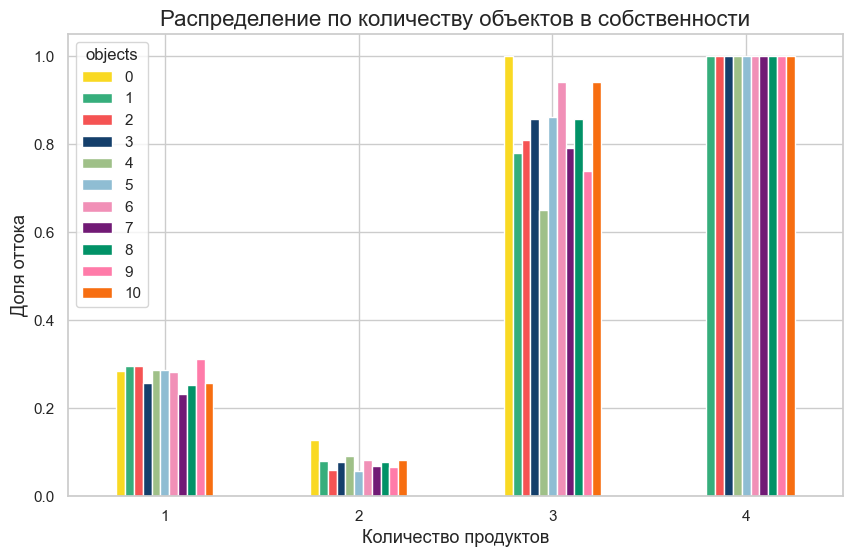

In [66]:
# вызов функции barplot распределение по объектам собственности
barplot('objects', 'mean', 'Распределение по количеству объектов в собственности', 'Доля оттока')

In [67]:
# доля оттока клиентов по продуктам и количеству объектов в собственности
pivoting(bank_data, 'objects', 'products', 'churn', 'mean', 2)

products,1,2,3,4
objects,,,,
0,0.28,0.13,1.00,NaN
1,0.30,0.08,0.78,1.0
2,0.30,0.06,0.81,1.0
3,0.26,0.08,0.86,1.0
4,0.29,0.09,0.65,1.0
5,0.29,0.06,0.86,1.0
6,0.28,0.08,0.94,1.0
7,0.23,0.07,0.79,1.0
8,0.25,0.08,0.86,1.0


Реже всего в отток уходят пользователи двух продуктов не зависимо от количества объектов в собственности (~ 8 %).

В среднем около 1/3 клиентов с одним продуктом уходят из банка.

У клиентов с 3-мя продуктами самый высокий процент ухода (от 65 % до 100 % в зависимости от числа объектов собственности).

**Баланс на счете:**

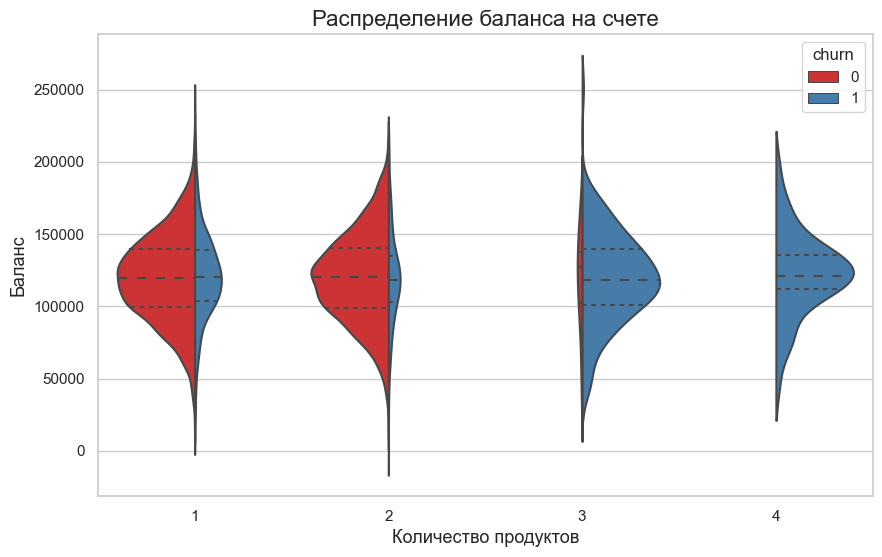

In [68]:
# вызов функции для вывода распределения баланса на счете (горизонтальные линии - квартили)
violinplot(bank_data, 'balance', 'Распределение баланса на счете', 'Баланс')

Данные распределены нормально. Медианное значение баланса у оставшихся клиентов с тремя продуктами больше, чем в остальных случаях. Уточним значения:

In [69]:
# медианные значения баланса ушедших и оставшихся клиентов по продуктам
pivoting(bank_data, 'churn', 'products', 'balance', 'median', 0)

products,1,2,3,4
churn,,,,
0,119679.0,120023.0,127222.0,NaN
1,120393.0,118284.0,117928.0,120968.0


In [70]:
# распределение клиентов с заполненным балансом по числу продуктов и оттоку 
pivoting(bank_data, 'churn', 'products', 'balance', 'count', 0)

products,1,2,3,4
churn,,,,
0,3108.0,1728.0,10.0,NaN
1,1071.0,262.0,158.0,46.0


Больше всего средств на счету у оставшихся клиентов, использующих 3 продукта(127 222 у.е.). При этом таких клиентов всего 10, так что не стоит считать полученный результат правдивым.

**Кредитная карта:**

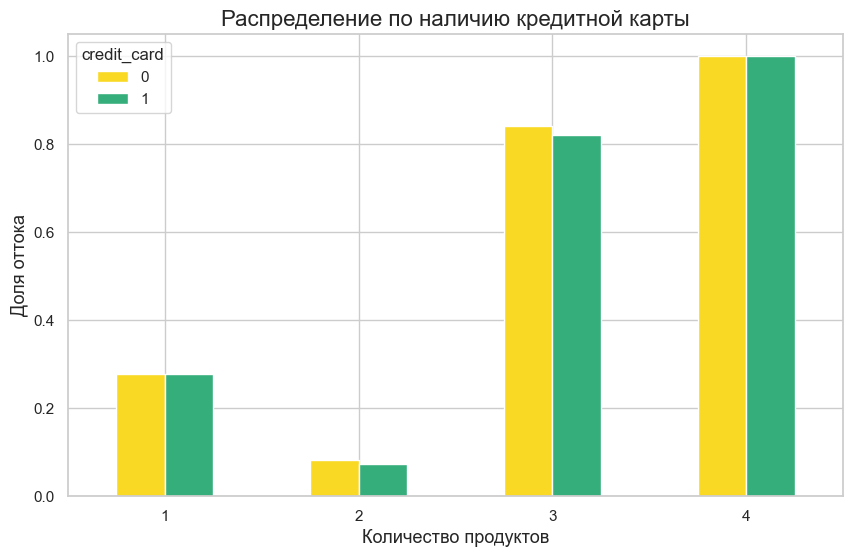

In [71]:
# вызов функции barplot распределение наличя кредитной карты по количеству продуктов и оттоку
barplot('credit_card', 'mean', 'Распределение по наличию кредитной карты', 'Доля оттока')

In [72]:
# доля оттока клиентов по продуктам и наличию кредитной карты
pivoting(bank_data, 'credit_card', 'products', 'churn', 'mean', 2)

products,1,2,3,4
credit_card,,,,
0,0.28,0.08,0.84,1.0
1,0.28,0.07,0.82,1.0


Наличие кредитной карты не влияет на долю оттока.

**Активность:**

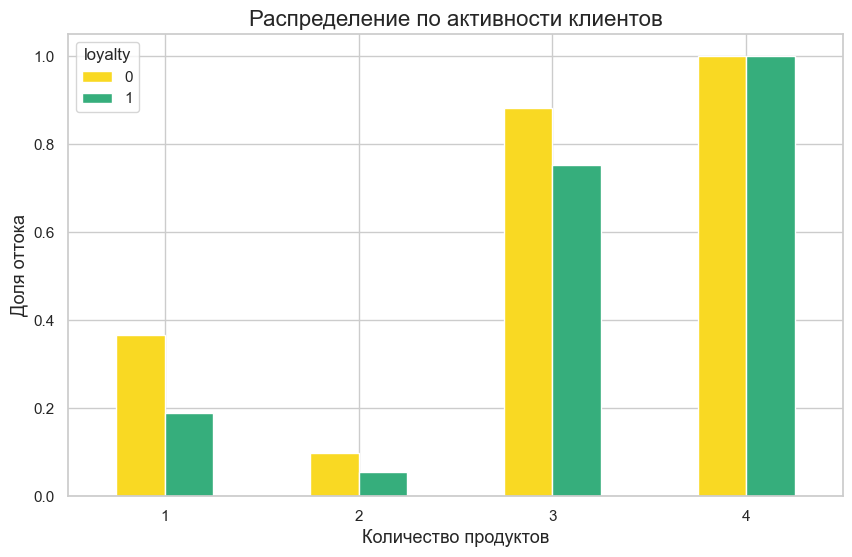

In [73]:
# вызов функции barplot распределение по активности
barplot('loyalty', 'mean', 'Распределение по активности клиентов', 'Доля оттока')

In [74]:
# доля отток клиентов по активности и количеству продуктов
pivoting(bank_data, 'loyalty', 'products', 'churn', 'mean', 2)

products,1,2,3,4
loyalty,,,,
0,0.37,0.10,0.88,1.0
1,0.19,0.06,0.75,1.0


In [75]:
# средняя активность клиента по количеству продуктов и городам
pivoting(bank_data, 'city', 'products', 'loyalty', 'mean', 2)

products,1,2,3,4
city,,,,
Ростов Великий,0.47,0.55,0.43,0.42
Рыбинск,0.55,0.51,0.42,0.29
Ярославль,0.50,0.54,0.42,0.59


In [76]:
# средняя активность клиентов по возрастным категориям и количеству продуктов
pivoting(bank_data, 'age_group', 'products', 'loyalty', 'mean', 2)

products,1,2,3,4
age_group,,,,
65 лет и старше,0.82,0.94,0.56,1.00
до 24 лет,0.55,0.64,NaN,NaN
от 25 до 44 лет,0.50,0.50,0.43,0.48
от 45 до 64 лет,0.49,0.63,0.41,0.47


В целом у неактивных клиентов процент оттока выше в сравнении с активными.

В среднем клиенты с 2-мя продуктами более активные (0.53), наименьшая активность характерна клиентам с 3-мя продуктами. 

В разрезе возрастов наибольшую активность проявляют клиенты 65+ лет.

**Оцененная заработная плата:**

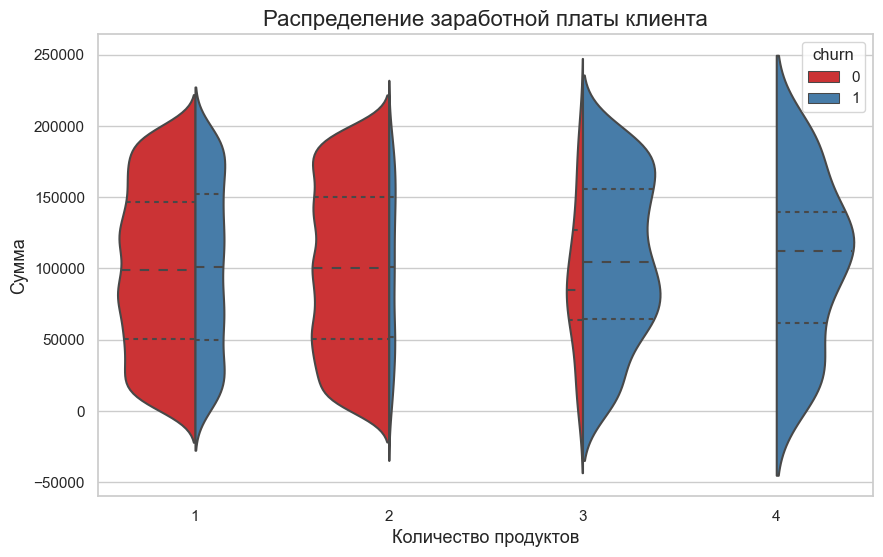

In [77]:
# вызов функции для вывода распределения заработной платы (горизонтальные линии - квартили)
violinplot(bank_data, 'estimated_salary', 'Распределение заработной платы клиента', 'Сумма')

In [78]:
# медианная зарплата по продуктам с учетом оттока
pivoting(bank_data, 'churn', 'products', 'estimated_salary', 'median', 0)

products,1,2,3,4
churn,,,,
0,98646.0,100610.0,84907.0,NaN
1,101109.0,101342.0,104612.0,112163.0


In [79]:
# количество клиентов по продуктам и зарплате
pivoting(bank_data, 'churn', 'products', 'estimated_salary', 'count', 0)

products,1,2,3,4
churn,,,,
0,3675.0,4242.0,46.0,NaN
1,1409.0,348.0,220.0,60.0


Медианная заработная плата клиентов примерно на одном уровне в 1 и 2 группе (3 и 4 не берем в расчет из-за небольшого количества наблюдений), следовательно этот показатель не влияет на отток пользователей.

### Промежуточные выводы

Проведена сегментация пользователей банка по количеству потребляемых продуктов с учетом оттока, что позволяет сделать следующие выводы:

1) Все пользователи 4-х продуктов (60 человек) покинули банк. В среднем меньший отток клиентов среди тех, кто использует 2 продукта. Около трети клиентов с одним продуктом уходят из банка. Очень высок процент ухода среди пользователей 3-х продуктов ~83 %.

2) Вне зависимости от количества продуктов клиенты ушедшие в отток в среднем имели более низкие баллы кредитного скоринга в сравнении с оставшимися;

3) Мужчины предпочитают пользоваться 1-м и 2-мя продуктами, в то время, как среди пользователей 3-х и 4-х продуктов преобладают женщины. Женщины чаще мужчин уходят в отток;

4) В отношении оттока поведение жителей Рыбинска и Ярославля можно считать похожим. Жители Ростова Великого активнее покидают банк. 90 % клиентов Ростова Великого, 79 % клиентов Рыбинска и Ярославля, пользовавшиеся 3-мя продуктами прекратили отношения с банком;

5) Возрастная группа от 45 до 64 лет показывает наивысшую долю оттока:

- 1 продукт - 58 %;

- 2 продукта - 22 %;

- 3 продукта - 99 %;

- 4 продукта - 100 %.

Клиенты до 24 лет:

- пользуются 1 и 2-мя продуктами;

- наименьшая доля оттока - по 9 % для клиентов с 1-м и 2-мя продуктами.

Клиенты от 25 до 44 лет, а также клиенты 65+ (пенсионеры):

- имеют высокий процент оттока в случае с 3-мя продуктами: 74 % и 56 % соответсвенно;

- предпочитают два продукта одному (уровень оттока меньше - 5 % и 7% против 18 % и 19 %).

6) Реже всего в отток уходят пользователи двух продуктов не зависимо от количества объектов в собственности (~ 8 %). 

7) Баланс на счете, заработная плата и наличие кредитной карты не влияют на отток пользователей;

8) В целом у неактивных клиентов процент оттока выше в сравнении с активными. В среднем клиенты с 2-мя продуктами более активные (0.53), наименьшая активность характерна клиентам с 3-мя продуктами. В разрезе возрастов наибольшую активность проявляют клиенты 65+ лет.

## Проверка статистических гипотез

### Доходы клиентов, которые пользуются двумя продуктами банка, и теми, которые пользуются одним, различаются

**Нулевая гипотеза (Н0):** распределение доходов клиентов, использующих два продукта банка соответствует распределению доходов клиентов, пользующихся одним продуктом. 

**Альтернативная гипотеза (Н1):** распределения доходов различаются.

Построим гистограммы каждой выборки:

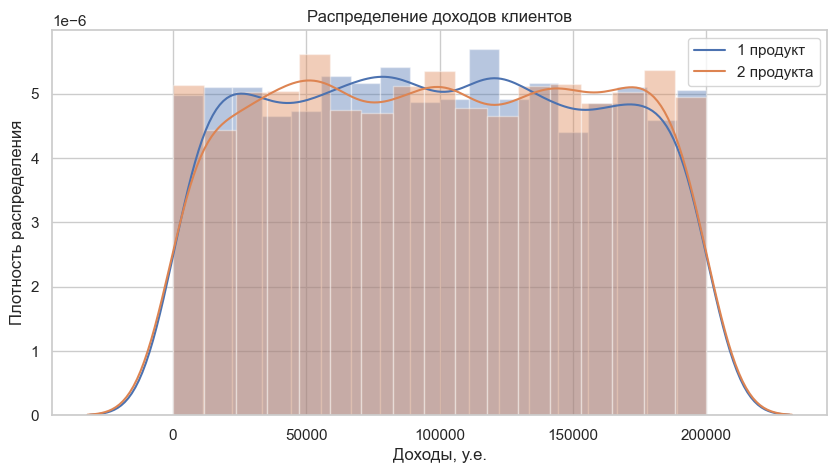

In [80]:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.distplot(bank_data.query('products == 1')['estimated_salary'], )
sns.distplot(bank_data.query('products == 2')['estimated_salary'], )
plt.legend(labels=['1 продукт', '2 продукта'])
plt.ylabel('Плотность распределения')
plt.xlabel('Доходы, у.е.')
plt.title('Распределение доходов клиентов')
plt.show()

Распределение данных не похоже на нормальное, визуально различия между доходами двух групп несущественны. При проверке гипотезы будем использовать критерий p-value, критический уровень статистической значимости примем равным 0.05. Воспользуемся непараметрическим критерием Манна-Уитни.

In [81]:
# статистический критерий Манна-Уитни, p-value
alpha = 0.05
results = st.mannwhitneyu(bank_data.query('products == 1')['estimated_salary'],
                          bank_data.query('products == 2')['estimated_salary'],
                          alternative = 'two-sided')
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: между распределениями доходов есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать распределения доходов между группами разными'
    )
print()

p-значение:  0.4079566651927651
Не получилось отвергнуть нулевую гипотезу, нет оснований считать распределения доходов между группами разными



Не получилось отвергнуть нулевую гипотезу: сделать вывод о том, что распределение доходов клиентов, которые пользуются двумя продуктами банка, и тех, которые пользуются одним, различаются, нельзя.

### Активность клиентов младше 45 лет и старше 45 лет отличается

Нулевая гипотеза (Н0): доля активных клиентов до 45 лет и после 45 лет одинакова;

Альтернативная гипотеза (Н1): доля активных клиентов отличается.

Построим гистограммы каждой выборки:

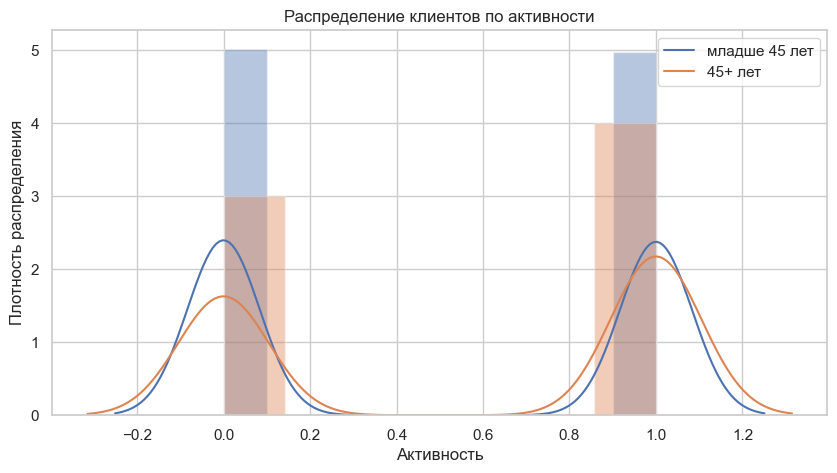

In [82]:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.distplot(bank_data.query('age < 45')['loyalty'])
sns.distplot(bank_data.query('age >= 45')['loyalty'])
plt.legend(labels=['младше 45 лет', '45+ лет'])
plt.ylabel('Плотность распределения')
plt.xlabel('Активность')
plt.title('Распределение клиентов по активности')
plt.show()

In [83]:
# сводная таблица средняя активность клиентов по среднему возрасту и количеству продуктов
round(bank_data.pivot_table(index = 'age_group', values = 'loyalty', aggfunc = 'mean'),2)

,loyalty
age_group,
65 лет и старше,0.87
до 24 лет,0.59
от 25 до 44 лет,0.50
от 45 до 64 лет,0.53


На первый взгляд, в активности пользователей видна разница. Для проверки гипотезы о равенстве долей признака в двух независимых выборках будем использовать z_value, критический уровень статистической значимости примем равным 0.05.

In [84]:
alpha = 0.05 # критический уровень статистической значимости

# пропорция активности клиентов моложе 45 лет:
p1 = bank_data.query('age < 45')['loyalty'].mean()

# пропорция активности клиентов 45 лет и старше:
p2 = bank_data.query('age >= 45')['loyalty'].mean()

# пропорция успехов в комбинированном датасете:
p_combined = (len(bank_data.query('age < 45 and loyalty == 1')['loyalty']) + len(bank_data.query('age >= 45 and loyalty == 1')['loyalty']))/ (len(bank_data.query('age < 45')['loyalty']) + len(bank_data.query('age >= 45 and loyalty == 1')['loyalty']))

# разница пропорций в датасетах
difference = p1 - p2


# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/(len(bank_data.query('age < 45')['loyalty'])) + 1/(len(bank_data.query('age >= 45 and loyalty == 1')['loyalty']))))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  4.436370082405716e-07
Отвергаем нулевую гипотезу: между долями есть значимая разница


Отвергаем нулевую гипотезу, разница в пропорциях при указанных размерах выборок достаточна, чтобы говорить о статистически значимом различии.

### Промежуточные выводы

В результате проверки двух статистических гипотез выяснили, что:

1) Распределения доходов клиентов, которые пользуются двумя продуктами банка, и тех, которые пользуются одним, не различаются.

2) Доля активных клиентов младше 45 лет и старше 45 лет различается.

## Выводы и рекомендации

На основании проведенного анализа и сегментации по количеству используемых продуктов для стратегии взаимодействия с пользователями банка и их удержания можно порекомендовать:

- предлагать клиентам два наиболее успешных продукта, для которых характерен наименьший отток;

- дополнительно выяснить причины высокого оттока клиентов с оставшимися двумя продуктами;

- клиентам, использующим только один продукт, предлагать воспользоваться вторым (например, помимо зарплатного счета открыть вклад или брокерский счет). Было выяснено, что доля оттока клиентов с одним продуктом выше доли оттока клиентов с двумя продуктами;

- привлекать в клиенты больше мужчин молодого возраста (до 24 лет), так как они реже уходят в отток;

- обратить внимание на клиентов из Ростова Великого, вероятно, высокий процент ухода связан с более выгодными условиями от конкурентов банка;

- поддерживать активность клиентов, в том числе категории старше 65 лет выгодными предложениями по пенсионным картам (например, бесплатное обслуживание);

- развивать мобильное приложение банка, кэшбек(бонусные) программы, акции "Приведи друга", % на остаток.